<a href="https://colab.research.google.com/github/meaghanspedden/visually-guided-stepping/blob/main/MES_MEGfaces_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
%matplotlib inline



# Introduction to MEG analysis

This workshop covers the basic MEG pipeline for event-related analysis:
loading data, epoching, averaging, plotting, and estimating cortical activity
from sensor data.
We start by importing the software MNE python.
Remember to run the cells in order, one at a time. The green check mark to the left of the cell will tell you that the code is finished running.

If you run into problems you can always start again by clicking 'Runtime' and restart from the menu at the top of the screen.

In [39]:
!pip install mne

In [40]:
import os
import numpy as np
import mne

## Load the data

The dataset we will analyze today is from anexperiment where...

We will start by looking at MEG data from a single subject.



We are interested in two features: (1) do we see a response that differs from baseline?
(2) how do responses compare in faces and scrabled faces?


In [41]:
import matplotlib.pyplot as plt

import mne
from mne.datasets import spm_face
from mne.preprocessing import ICA, create_eog_epochs
from mne import io, combine_evoked
from mne.minimum_norm import make_inverse_operator, apply_inverse

print(__doc__)

data_path = spm_face.data_path()
subjects_dir = data_path / "subjects"
spm_path = data_path / "MEG" / "spm"


raw_fname = str(spm_path / "SPM_CTF_MEG_example_faces%d_3D.ds")

raw = io.read_raw_ctf(raw_fname % 1, preload=True)  # Take first run
raw.resample(120.0, npad="auto")

Automatically created module for IPython interactive environment
ds directory : /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01   -0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01   -0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds/SPM_CTF_MEG_example_faces1_3D.meg4: 
    System clock channel is available, checking which samples are v

<RawCTF | SPM_CTF_MEG_example_faces1_3D.meg4, 340 x 81118 (676.0 s), ~211.0 MB, data loaded>

Let's start by plotting the MEG channel time series. Note that you cannot scroll through the plot here in google co-lab, but try changing the duration variable (in seconds) to look at different durations of the data.
Try duration=1 (zoom in) and duration=10 (zoom out).

What do you thing the 'Trig' lines represent?

Note the diff I think is most visible with 5 sec duratin


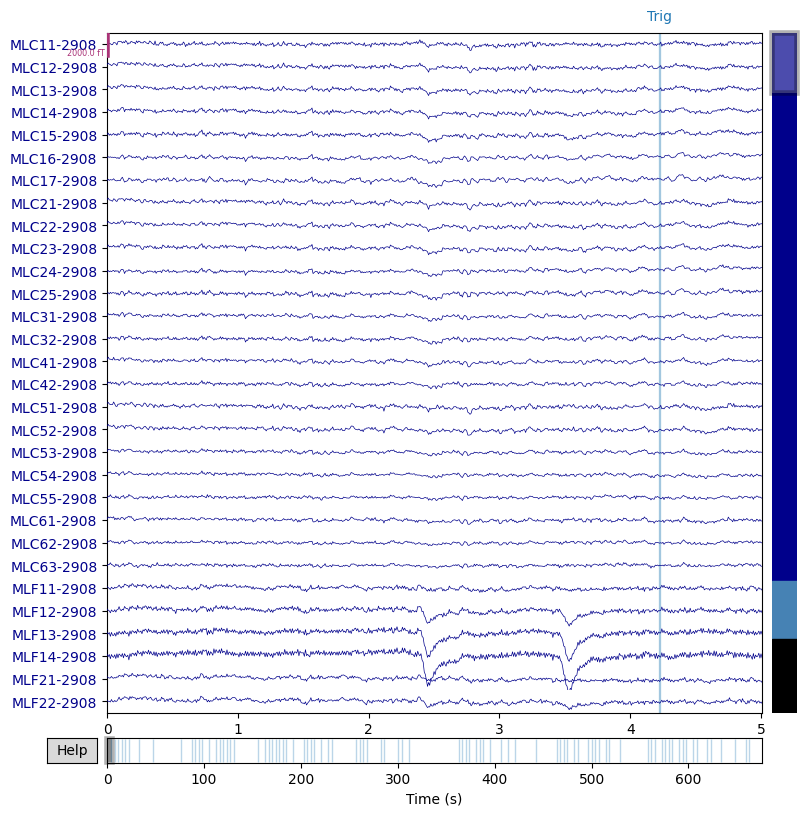

In [42]:
raw.plot(n_channels=30, duration=5, scalings=1e-12, title='Raw data')
# Show the plot
plt.show()

## Preprocessing
A common preprocessing step is filtering, which helps get rid of interference in the signals. Here we will band pass filter the data, which means that we attenuate frequencies below the number specified in the ´freq low' variable and above the number specified in the 'freq high' variable.

Here we will look at the frequency band from 0.1-40 Hz, because the speed of the responses we are looking at lies in this range.
Compare the data to the data plotted above - how has the filtering changed the time series?


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 397 samples (3.308 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.3s


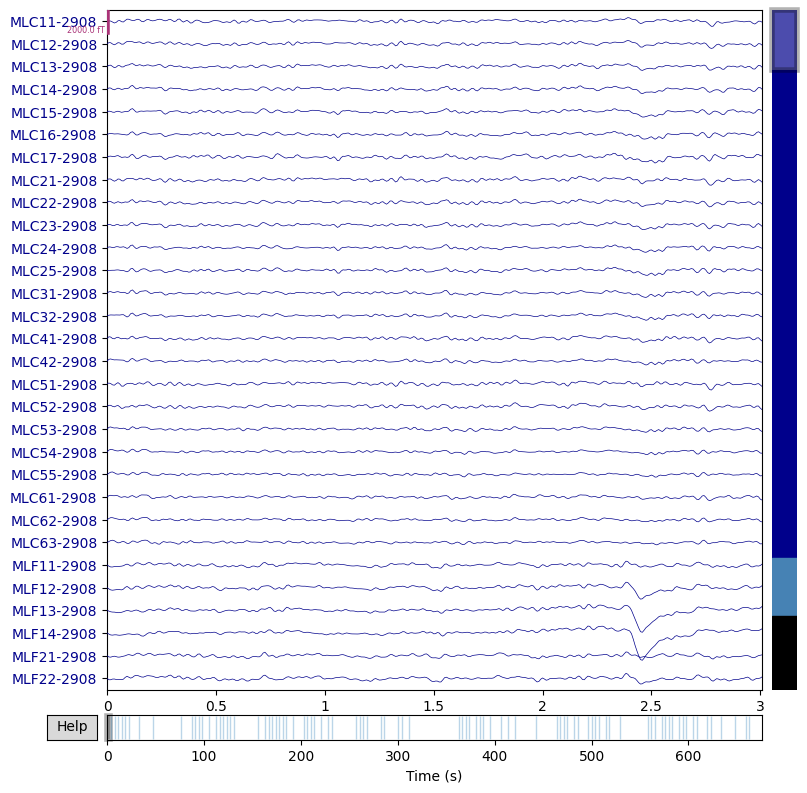

In [43]:

# Define the frequency range for the band-pass filter
freq_low = 1  # Lower frequency limit (in Hz)
freq_high = 30  # Upper frequency limit (in Hz)

picks = mne.pick_types(raw.info, meg=True, exclude="bads")
raw.filter(freq_low, freq_high, method="fir", fir_design="firwin")

# Plot the filtered time series data
raw.plot(n_channels=30, duration=3, scalings=1e-12, title='Filtered Data')

# Show the plot
plt.show()


## Looking at events in the data: when do the stimuli occur?
We want to look at the brain responses time-locked to stimulus presentation (i.e. when the participant views the face).

We do this using a channel in the data that records a signal every time a stimulus is presented. The following code makes a figure that shows you when the stimuli are presented throughout the experiment.

Note the number of trials here.



172 events found
Event IDs: [1 2 3]


<ipython-input-44-9986a09fdb3d>:9: RuntimeWarning: event 3 missing from event_id will be ignored
  mne.viz.plot_events(events, raw.info["sfreq"],event_id=event_dict)


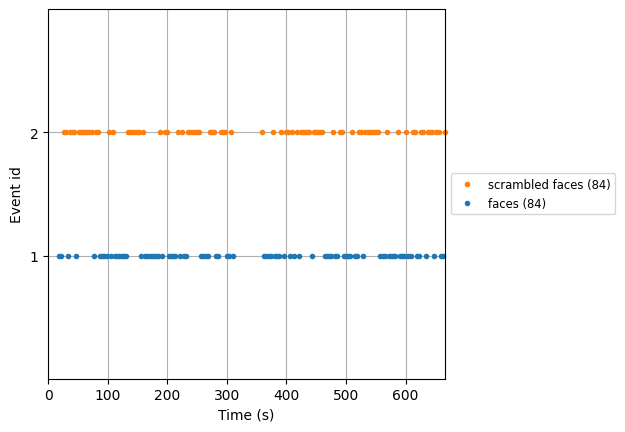

In [44]:
events = mne.find_events(raw, stim_channel="UPPT001")

event_dict = {
    "faces": 1,
    "scrambled faces": 2,
}

# plot the events to get an idea of the paradigm
mne.viz.plot_events(events, raw.info["sfreq"],event_id=event_dict)


plt.show()



## Epoching continuous data

Now we want to chop the data up - or 'epoch' it - into segments time-locked to the stimuli. At the same time we will also reject data chunks with excessively large values, suggesting that they contain artifacts.




In [45]:
tmin, tmax = -0.2, 0.6
baseline = None  # no baseline as high-pass is applied
reject = dict(mag=5e-12)

epochs = mne.Epochs(
    raw,
    events,
    event_dict,
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    preload=True,
    reject=reject,
)

Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 97 original time points ...
    Rejecting  epoch based on MAG : ['MLT35-2908', 'MLT42-2908', 'MLT45-2908', 'MLT52-2908', 'MRT14-2908', 'MRT43-2908', 'MRT44-2908', 'MRT45-2908', 'MRT53-2908', 'MRT54-2908']
1 bad epochs dropped


Let's take a look at the data!
First we'll plot the response to faces.
Take a look at the image plot and try too figure out what is on each axis. Is there a pattern that sticks out in the plot?
Is the response as strong on other channels as on 'MLC24-2908'? (try MLF22-2908).

What do you think the trace at the bottom shows?



Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated


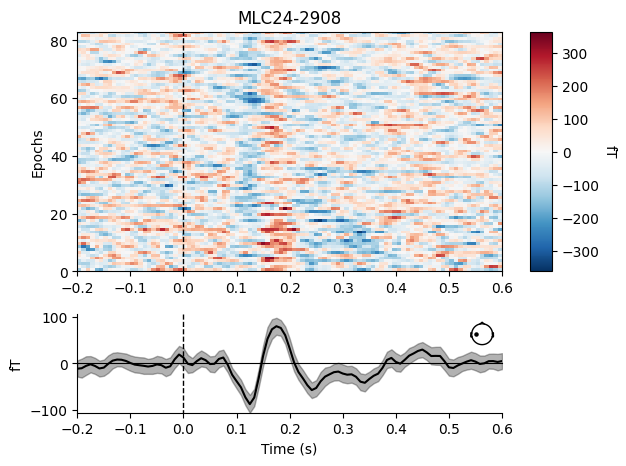

[<Figure size 640x480 with 4 Axes>]

In [46]:
# we have epochs object
epochs_faces = epochs[epochs.events[:, -1] == 1]
epochs_scrambled = epochs[epochs.events[:, -1] == 2]
epochs_scrambled.plot_image(picks=["MLC24-2908"])

Compare average of both conditions
explain global field potential

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
combining channels using "gfp"
combining channels using "gfp"


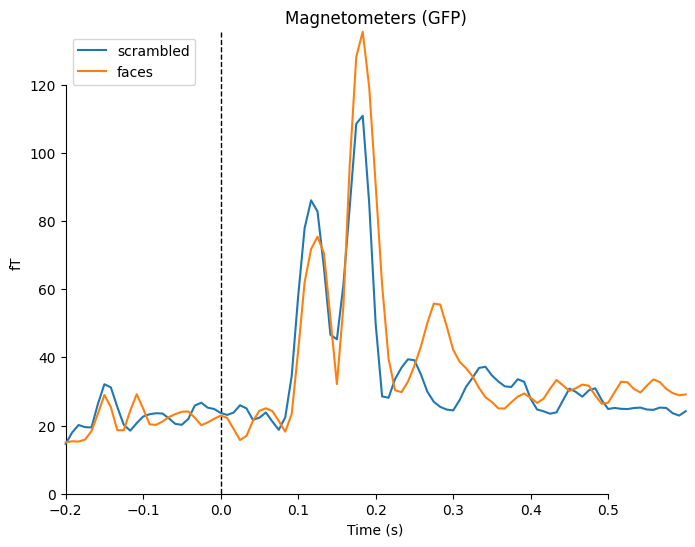

[<Figure size 800x600 with 1 Axes>]

In [47]:
# List of Evoked objects, such as [epochs[k].average() for k in event_ids]
evoked = [epochs[k].average() for k in event_dict]
contrast = combine_evoked(evoked, weights=[-1, 1])  # Faces - scrambled
evoked.append(contrast)

faces_evoked = epochs_faces.average()
scrambled_evoked = epochs_scrambled.average()

mne.viz.plot_compare_evokeds(
    dict(scrambled=scrambled_evoked, faces=faces_evoked),picks='mag', combine='gfp')


We can also look at the *spatial* distribution of the activity using a topographical map. Let's start with the early response at around 100 ms.
Where do the plots suggest the activity might be coming from? Is this what you expected?


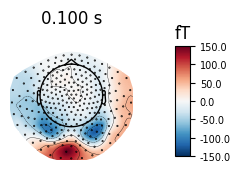

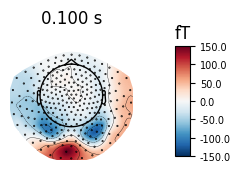

In [48]:
faces_evoked.plot_topomap(times=[0.100])

And let's do the same for the later response around 170 ms - what kind of spatial pattern do you expect here?

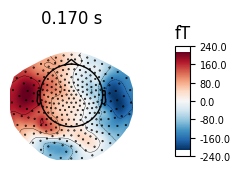

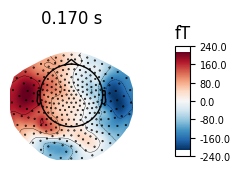

In [26]:
faces_evoked.plot_topomap(times=[0.170])

## Inverse modeling




In [49]:
src = subjects_dir / "spm" / "bem" / "spm-oct-6-src.fif"
bem = subjects_dir / "spm" / "bem" / "spm-5120-5120-5120-bem-sol.fif"
trans_fname = spm_path / "SPM_CTF_MEG_example_faces1_3D_raw-trans.fif"


forward = mne.make_forward_solution(contrast.info, trans_fname, src, bem)

Source space          : /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-oct-6-src.fif
MRI -> head transform : /root/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D_raw-trans.fif
Measurement data      : instance of Info
Conductor model   : /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /root/mne_data/MNE-spm-face/subjects/spm/bem/spm-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999622  0.006802  0.026647      -2.80 mm
    -0.014131  0.958276  0.285497       6.72 mm
    -0.023593 -0.285765  0.958009       9.43 mm
     0.000000  0.000000  0.000000       1.00

Read 303 MEG channels from info
Read 29 MEG compensation channels from info
5 compensation data sets in info
Setting up compensation data...
    Desired compensation data (3) found.
    All compensation 

Finally, in order to plot the source estimate on the subject's cortical
surface we'll also need the path to the sample subject's structural MRI files
(the ``subjects_dir``):



In [50]:
# path to subjects' MRI files
#what I can do here is save and import a nice picture?

# estimate noise covarariance
noise_cov = mne.compute_covariance(epochs, tmax=0, method="shrunk", rank=None)
snr = 3.0
lambda2 = 1.0 / snr**2
method = "dSPM"

inverse_operator = make_inverse_operator(
    contrast.info, forward, noise_cov, loose=0.2, depth=0.8
)

# Compute inverse solution on contrast
stc = apply_inverse(contrast, inverse_operator, lambda2, method, pick_ori=None)
# stc.save('spm_%s_dSPM_inverse' % contrast.comment)

# Plot contrast in 3D with mne.viz.Brain if available

# brain.save_image('dSPM_map.png')
# plot the STC

#stc.plot(initial_time=0.1, subjects_dir=subjects_dir, backend='matplotlib')

#stc.plot(initial_time=0.1, hemi='lh', views='lat', subjects_dir=subjects_dir, backend='matplotlib')



Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 3.5e-09 (2.2e-16 eps * 274 dim * 5.8e+04  max singular value)
    Estimated rank (mag): 274
    MAG: rank 274 computed from 274 data channels with 0 projectors
Reducing data rank from 274 -> 274
Estimating covariance using SHRUNK
Done.
Number of samples used : 4175
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 274 channels.
    274 out of 274 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 274 channels
Creating the depth weighting matrix...
    274 magnetometer or axial gradiometer channels
    limit = 8109/8196 = 10.042069
    scale = 4.04483e-11 exp = 0.8
Applying 

Using control points [2.58296981 2.92472473 5.53082012]
Octahedron subdivision grade 6
    Triangle neighbors and vertex normals...
Loading geometry from /root/mne_data/MNE-spm-face/subjects/spm/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
    10 smooth iterations done.


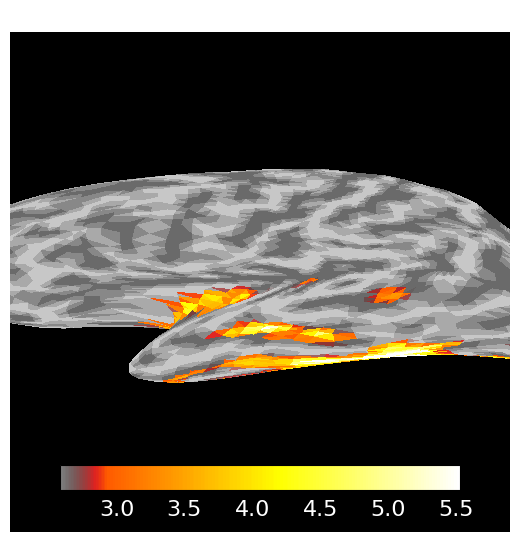

AttributeError: ignored

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 200))  # Adjust the width and height as needed

brain= stc.plot(
    hemi="lh",
    subjects_dir=subjects_dir,
    initial_time=0.170,
    #views="ven",
    backend='matplotlib',
figure=fig
)
plt.show()

